In [1]:
import os
import numpy as np
from datetime import datetime 
import pandas_datareader.data as web

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM 

In [2]:
# Environmental Variables
COMPANY = 'AAPL'
PREDICT_DAYS = 60


# GRAB STOCK DATA
data = web.DataReader(COMPANY, 'av-daily', 
        start=datetime(2020, 2, 9), 
        end=datetime(2021, 5, 24), 
        api_key='ALPHAVANTAGE_API_KEY')

data['close']

2020-02-10    321.55
2020-02-11    319.61
2020-02-12    327.20
2020-02-13    324.87
2020-02-14    324.95
               ...  
2021-05-18    124.85
2021-05-19    124.69
2021-05-20    127.31
2021-05-21    125.43
2021-05-24    127.10
Name: close, Length: 325, dtype: float64

In [3]:
# Prepare for the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1,1))
# shape of data
np.shape(scaled_data)



(325, 1)

In [4]:
x_train = []
y_train = []

# use 60 data to predict the stock price in the next day
for x in range(PREDICT_DAYS, len(scaled_data)):
    x_train.append(scaled_data[x-PREDICT_DAYS:x]) # range of data : PREDICT_DAYS
    y_train.append(scaled_data[x, 0])

print(f"type of training data : {type(x_train)}, shape : {np.shape(x_train)}")

x_train, y_train = np.array(x_train), np.array(y_train)

type of training data : <class 'list'>, shape : (265, 60, 1)


In [5]:
# Build the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)



Epoch 1/25


In [ ]:
# Test the MODEL Accuracy on Existing Data
test_data = web.DataReader(COMPANY, 'av-daily', 
        start=datetime(2022, 1, 1), 
        end=datetime.now(), 
        api_key='ALPHAVANTAGE_API_KEY')

# divide the dataset into the shape of training data
actual_price = test_data['close'].values
model_input = actual_price.reshape(-1, 1)

model_input = scaler.transform(model_input)

np.shape(model_input)

# establish testing data
x_test = []

for x in range(PREDICT_DAYS, len(model_input)):
        x_test.append(model_input[x-PREDICT_DAYS:x, 0])

x_test = np.array(x_test)
# input shape : (length of data, shape of mat, 1) 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(f"shape of the testing data : {x_test.shape}")
predict_result = model.predict(x_test)
predict_result = scaler.inverse_transform(predict_result)


shape of the testing data : (109, 60, 1)
4/4 [==============================] - 1s 21ms/step


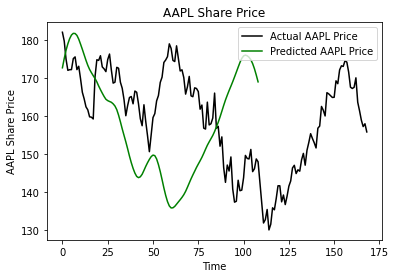

In [ ]:
# draw the prediction result 
import matplotlib.pyplot as plt

plt.plot(actual_price, color="black", label=f"Actual {COMPANY} Price")
plt.plot(predict_result, color="green", label=f"Predicted {COMPANY} Price")
plt.title(f"{COMPANY} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{COMPANY} Share Price")
plt.legend()
plt.show()
